Suggested Bin width: 0.00608364310378425
Suggested Number of bins: 14
Optimal Weibull parameters: shape (c) = 3.849, scale = 0.027, R² = 0.787


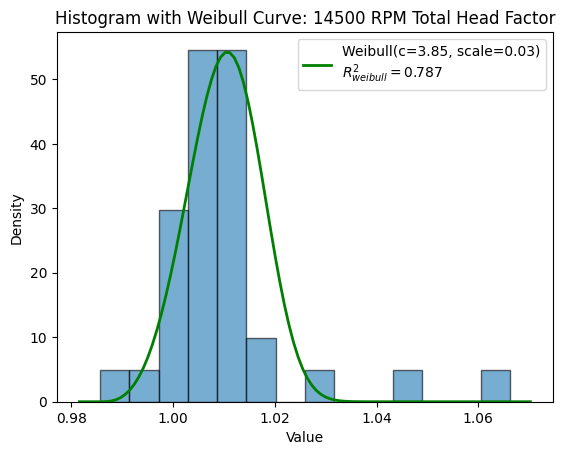


Expected value (Weibull): 1.0101
Standard Error of Mean: ±0.0033 or ±0.32% of the Expected Value
Standard Deviation : 0.0012
Standard Error of Mean Margin: 0.65% of the Expected Value
Number of samples = 35, which is 4.0% of Total Data


In [164]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import weibull_min, t
import scipy.special as sps  # for the gamma function

# 14500 RPM Head
# Sample data - replace this list with your actual data
# remove outlier ,1.0662,1.0469
data = [1.0152,0.9952,1.0002,1.0662,1.0094,1.0084,1.0018,1.0101,1.0142,1.0130,0.9993,1.0031,1.0090,1.0046,1.0086,1.0129,1.0078,1.0034,1.0283,1.0114,1.0469,1.0029,1.0201,1.0135,0.9999,1.0033,1.0082,0.9856,0.9995,1.0011,1.0074,1.0121,1.0101,1.0136,1.0070]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.01
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 14500 RPM Total Head Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.004157665638767184
Suggested Number of bins: 9
Optimal Weibull parameters: shape (c) = 2.205, scale = 0.013, R² = 0.959


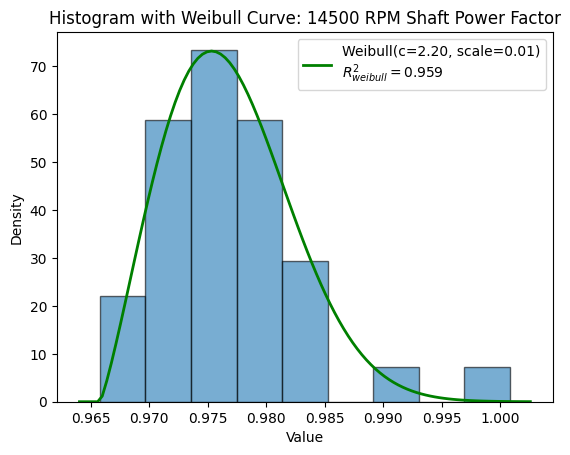


Expected value (Weibull): 0.9769
Standard Error of Mean: ±0.0025 or ±0.25% of the Expected Value
Standard Deviation : 0.0009
Standard Error of Mean Margin: 0.50% of the Expected Value
Number of samples = 35, which is 4.0% of Total Data


In [162]:
# 14500 RPM Power
# Sample data - replace this list with your actual data
data = [0.9803,0.9742,0.9760,1.0008,0.9745,0.9726,0.9717,0.9771,0.9782,0.9805,0.9705,0.9715,0.9776,0.9735,0.9782,0.9814,0.9757,0.9725,0.9849,0.9781,0.9901,0.9761,0.9824,0.9813,0.9696,0.9759,0.9793,0.9658,0.9728,0.9683,0.9747,0.9756,0.9750,0.9817,0.9732]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.001
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 14500 RPM Shaft Power Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.009538174112465752
Suggested Number of bins: 9
Optimal Weibull parameters: shape (c) = 1.460, scale = 0.022, R² = 0.846


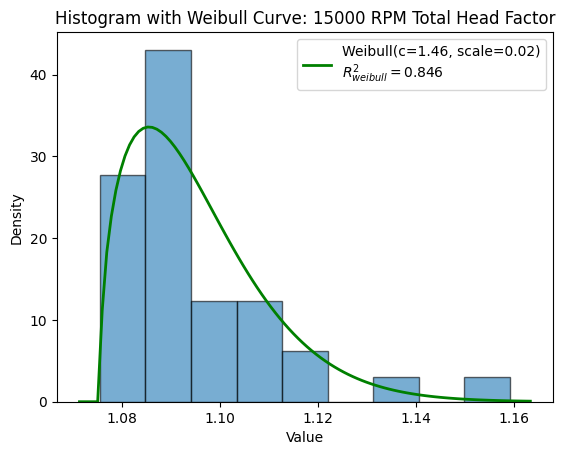


Expected value (Weibull): 1.0956
Standard Error of Mean: ±0.0064 or ±0.58% of the Expected Value
Standard Deviation : 0.0023
Standard Error of Mean Margin: 1.17% of the Expected Value
Number of samples = 35, which is 4.0% of Total Data


In [157]:
# 15000 RPM Head
# Sample data - replace this list with your actual data
data = [1.0823,1.0889,1.1112,1.1592,1.0790,1.0963,1.0902,1.1127,1.0931,1.0859,1.0914,1.0994,1.1166,1.0910,1.0878,1.0847,1.0831,1.1357,1.0836,1.0833,1.1024,1.1070,1.1150,1.0900,1.0903,1.0902,1.0783,1.0927,1.1061,1.0809,1.0869,1.0756,1.0976,1.0867,1.0893]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 15000 RPM Total Head Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")


Suggested Bin width: 0.004096523497020614
Suggested Number of bins: 9
Optimal Weibull parameters: shape (c) = 2.137, scale = 0.013, R² = 0.808


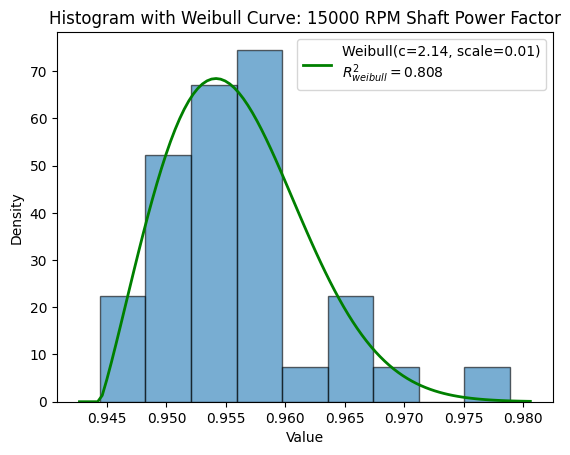


Expected value (Weibull): 0.9560
Standard Error of Mean: ±0.0026 or ±0.28% of the Expected Value
Standard Deviation : 0.0010
Standard Error of Mean Margin: 0.55% of the Expected Value
Number of samples = 35, which is 4.0% of Total Data


In [165]:
# 15000 RPM Power
# Sample data - replace this list with your actual data
data = [0.9500,0.9570,0.9587,0.9789,0.9444,0.9551,0.9586,0.9591,0.9565,0.9520,0.9562,0.9558,0.9619,0.9492,0.9555,0.9550,0.9473,0.9648,0.9537,0.9537,0.9577,0.9641,0.9683,0.9526,0.9523,0.9508,0.9494,0.9535,0.9664,0.9478,0.9513,0.9519,0.9590,0.9560,0.9559]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 15000 RPM Shaft Power Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.012918214455045929
Suggested Number of bins: 9
Optimal Weibull parameters: shape (c) = 1.509, scale = 0.036, R² = 0.835


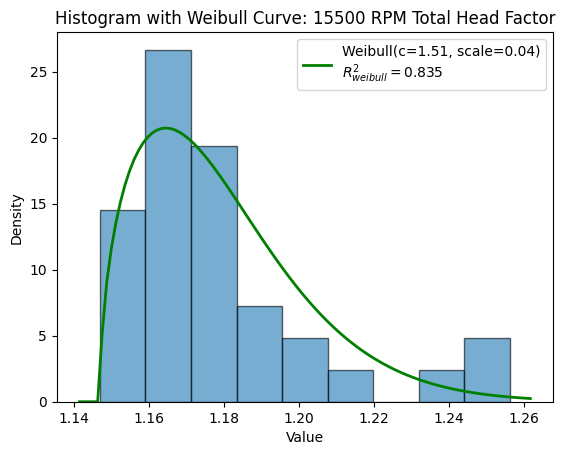


Expected value (Weibull): 1.1795
Standard Error of Mean: ±0.0103 or ±0.87% of the Expected Value
Standard Deviation : 0.0038
Standard Error of Mean Margin: 1.74% of the Expected Value
Number of samples = 34, which is 3.9% of Total Data


In [160]:
# 15500 RPM Head
# Sample data - replace this list with your actual data
data = [1.1800,1.2562,1.1894,1.1582,1.1633,1.2504,1.1723,1.2180,1.1820,1.1534,1.1606,1.1649,1.1608,1.1576,1.1971,1.1704,1.1652,1.1737,1.2356,1.1814,1.1794,1.1631,1.1828,1.1680,1.1470,1.1645,1.1949,1.1570,1.1845,1.1687,1.1764,1.1539,1.2027,1.1690]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 15500 RPM Total Head Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.006914408692784405
Suggested Number of bins: 6
Optimal Weibull parameters: shape (c) = 1.384, scale = 0.014, R² = 0.911


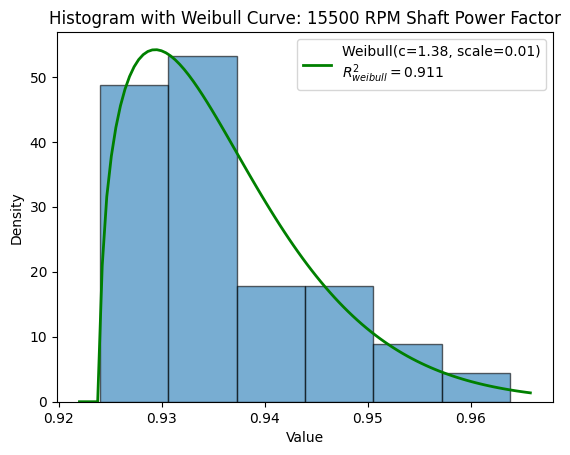


Expected value (Weibull): 0.9364
Standard Error of Mean: ±0.0042 or ±0.45% of the Expected Value
Standard Deviation : 0.0016
Standard Error of Mean Margin: 0.91% of the Expected Value
Number of samples = 34, which is 3.9% of Total Data


In [166]:
# 15500 RPM Power
# Sample data - replace this list with your actual data
data = [0.9311,0.9638,0.9428,0.9272,0.9331,0.9548,0.9328,0.9561,0.9354,0.9276,0.9342,0.9329,0.9240,0.9305,0.9460,0.9323,0.9270,0.9379,0.9459,0.9301,0.9384,0.9344,0.9305,0.9349,0.9271,0.9335,0.9462,0.9295,0.9431,0.9365,0.9305,0.9321,0.9444,0.9304]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.01
c_high = 2
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 15500 RPM Shaft Power Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")